# This notebook needs iPywidgets

In [1]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/mnt/s/_Data/160603 - EonHe M016v5/modules')
    from BEM import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data 
from HeliumSurface.static_surface import *
from ipywidgets import interact

%matplotlib inline

/home/ge/anaconda3/envs/lizards/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Resonator MW potential

In [192]:
# Load the data from the dsp file: 
path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160601 - M016v5 resonator xz cut Ex.dsp'
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160601 - M016v5 resonator xz cut Ex.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

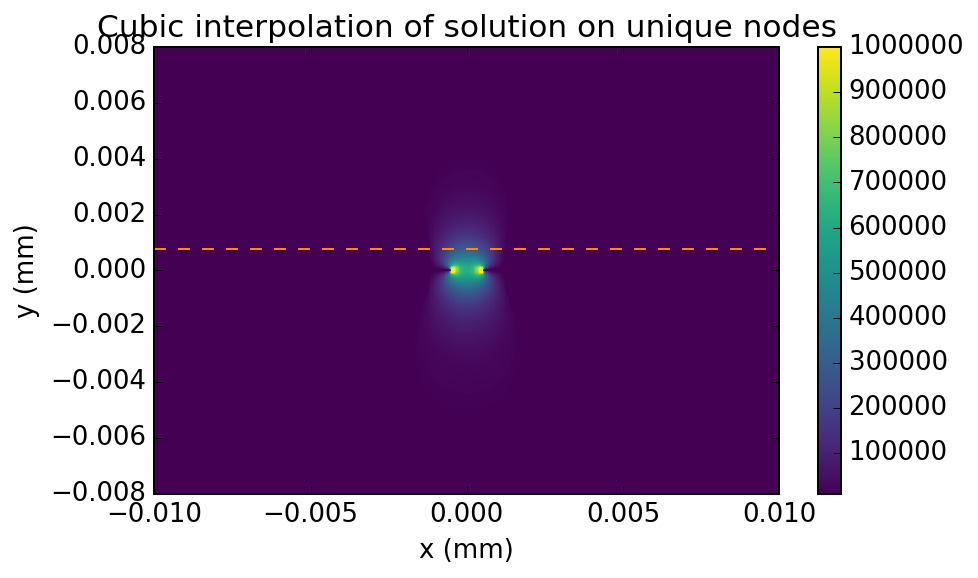

In [193]:
h = 0.78E-3
plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=np.linspace(-8E-3, 8E-3, 1001), clim=(1E4, 1E6), 
                                                     plot_axes='xy', cmap=plt.cm.viridis)

plt.hlines(h, bounding_box[0], bounding_box[1], linestyles='--', color='darkorange')

The mean electric field over the range (-0.00025, 0.00025) is 0.2972 V/um.


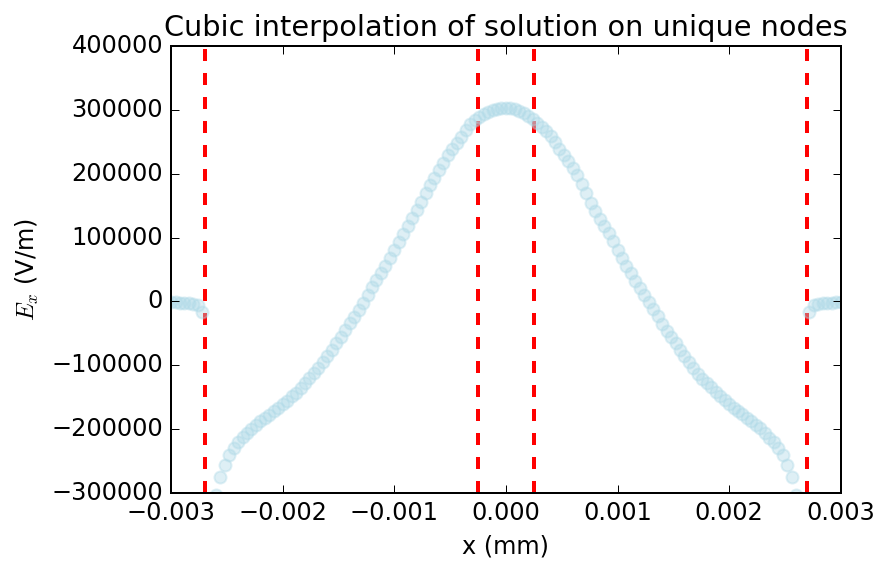

In [198]:
electron_min_x = -0.25E-3 #minimum value of x for the electron
electron_max_x = 0.25E-3 #maximum value of x for the electron

plt.figure(figsize=(6.,4.))
common.configure_axes(12)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=h, clim=(-3E5, 4E5), linestyle='None', 
                                                     plot_axes='xy', cmap=plt.cm.viridis, 
                                                     **common.plot_opt('lightblue', msize=6))
plt.xlim(-3E-3, 3E-3)
plt.ylabel(r"$E_x$ (V/m)")
plt.vlines((-0.25E-3, 0.25E-3, -2.7E-3, 2.7E-3), -3E5, 4E5, colors='r', lw=2.0, linestyles='--')
ax = plt.gca()
ax.set_axis_bgcolor('none')

meanEx = np.mean(Uinterp[0][np.logical_and(xinterp[0]>electron_min_x , xinterp[0]<electron_max_x)])
print "The mean electric field over the range %s is %.4f V/um." % ( (electron_min_x, electron_max_x), meanEx/1E6)

# Level meter curve

In [168]:
# Load the data from the dsp file: 
path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160530 - M016v5 resonator xz cut magE.dsp'
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160530 - M016v5 resonator xz cut magE.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

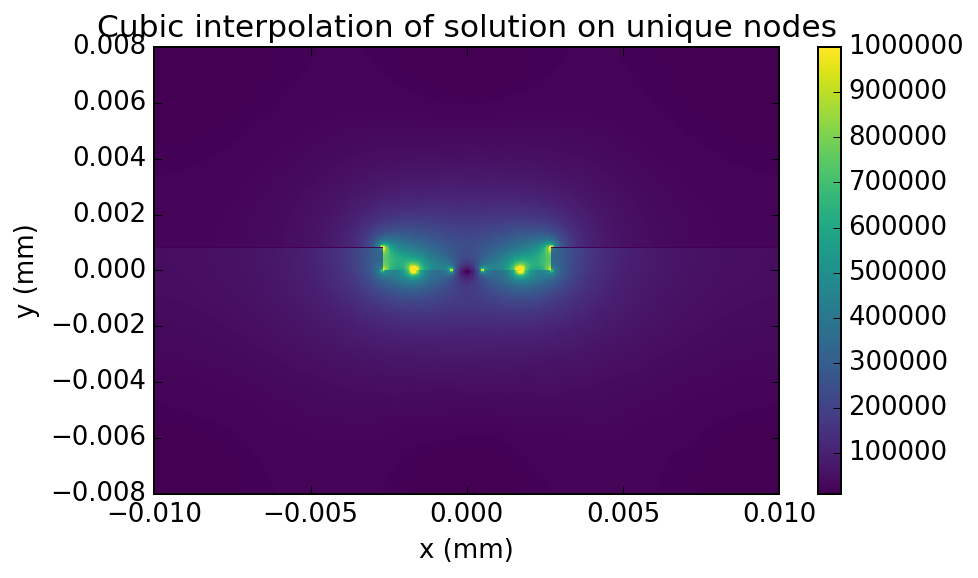

In [169]:
h = 0.78E-3
plt.figure(figsize=(7.,4.))
xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=np.linspace(-8E-3, 8E-3, 1001), clim=(1E4, 1E6), 
                                                     plot_axes='xy', cmap=plt.cm.viridis)

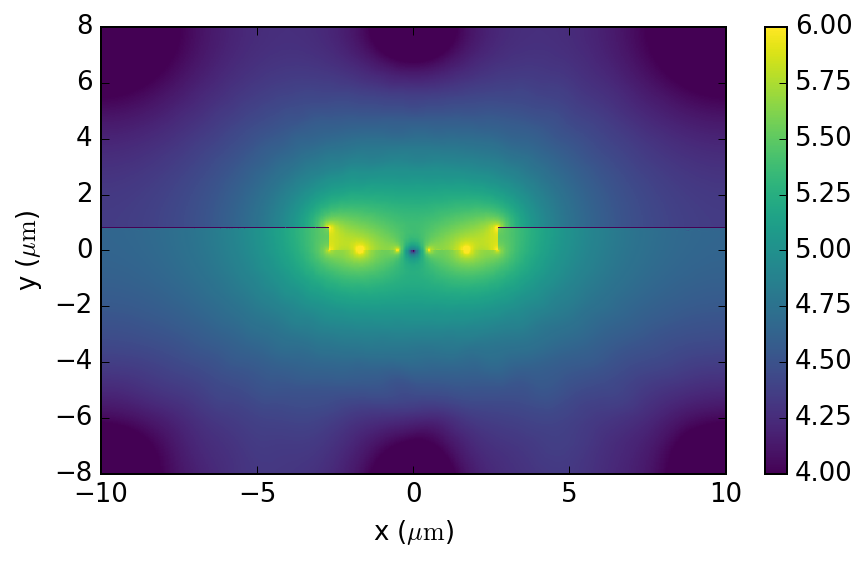

In [170]:
# This cell only serves as a test to see if integrate_energy gets the correct input
integrate_energy(xinterp.T * 1E-3, yinterp.T * 1E-3, Uinterp.T, (-10E-6, +10E-6), (-8E-6, 8E-6), epsilon_r = 1.00, 
                 do_plot=True, cmap=plt.cm.viridis, figsize=(7.,4.))
plt.clim(4, 6)

In [175]:
# Note: this code takes into account that the walls of the channel are not made of a conductor.
film_thickness = np.arange(0, 5E-6, 0.01E-6)
channel_width = 5.4E-6
channel_height = 0.8E-6
eps_silicon = 11.45 # Simulation was done with eps_silicon = 11.45
eps_helium = 1.056
eps_vacuum = 1.000
eps_ratio = list()
eps_eff = list()

X = xinterp.T * 1E-3
Y = yinterp.T * 1E-3
E = Uinterp.T

box_width = (bounding_box[1]-bounding_box[0])*1E-3
box_height = bounding_box[3]*1E-3

# First the case for no helium 
E_si = integrate_energy(X, Y, E, (-box_width/2., box_width/2.), (-box_height, 0), eps_silicon)
E_channel = integrate_energy(X, Y, E, (-channel_width/2., channel_width/2.), (0, channel_height), eps_vacuum) + \
            integrate_energy(X, Y, E, (-box_width/2., -channel_width/2.), (0, channel_height), eps_silicon) + \
            integrate_energy(X, Y, E, (+channel_width/2., box_width/2.), (0, channel_height), eps_silicon)
E_uppervac = integrate_energy(X, Y, E, (-box_width/2., box_width/2.), (channel_height, box_height), eps_vacuum)

# For normalization, integrate over entire region
E_squared = integrate_energy(X, Y, E, (-box_width/2., box_width/2.), (-box_height, box_height), eps_silicon)

# Now with helium 
for f in tqdm(film_thickness): 
    if f < 0: 
        raise ValueError('Bad choice of film thickness!')
    elif f < channel_height:
        E_film = integrate_energy(X, Y, E, (-channel_width/2., channel_width/2.), (0, f), eps_helium) + \
                 integrate_energy(X, Y, E, (-box_width/2., -channel_width/2.), (0, f), eps_silicon) + \
                 integrate_energy(X, Y, E, (+channel_width/2., box_width/2.), (0, f), eps_silicon)
        E_rest = integrate_energy(X, Y, E, (-channel_width/2., channel_width/2.), (f, channel_height), eps_vacuum) + \
                 integrate_energy(X, Y, E, (-box_width/2., -channel_width/2.), (f, channel_height), eps_silicon) + \
                 integrate_energy(X, Y, E, (+channel_width/2., box_width/2.), (f, channel_height), eps_silicon) + \
                 integrate_energy(X, Y, E, (-box_width/2., box_width/2.), (channel_height, box_height), eps_vacuum)
        
    elif f >= channel_height:
        E_film = integrate_energy(X, Y, E, (-channel_width/2., channel_width/2.), (0, channel_height), eps_helium) + \
                 integrate_energy(X, Y, E, (-box_width/2., -channel_width/2.), (0, channel_height), eps_silicon) + \
                 integrate_energy(X, Y, E, (+channel_width/2., box_width/2.), (0, channel_height), eps_silicon) + \
                 integrate_energy(X, Y, E, (-box_width/2., +box_width/2.), (channel_height, f), eps_helium)
        E_rest = integrate_energy(X, Y, E, (-box_width/2., box_width/2.), (f, box_height), eps_vacuum)
    
    eps_ratio.append((E_si + E_film + E_rest)/(E_si + E_channel + E_uppervac))
    eps_eff.append((E_si + E_film)/E_squared)

100%|██████████| 501/501 [00:00<00:00, 1715.21it/s]


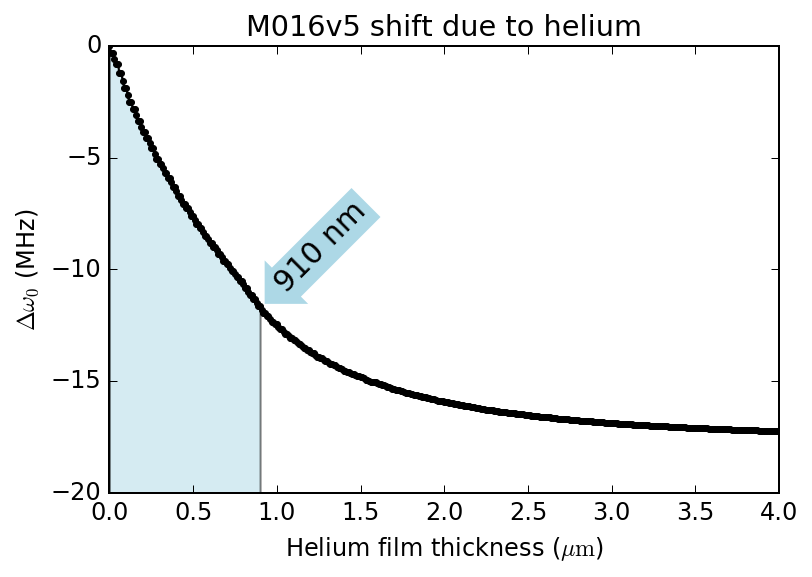

In [176]:
from ipywidgets import interact

w0_M016 = 5.67E9
resfreq_shift_M016 = -w0_M016*(1-1/np.sqrt(eps_ratio))

fig1 = plt.figure(figsize=(6.,4.))
common.configure_axes(12)

def plot_red_line(shift=-10):
    plt.plot(film_thickness*1E6, resfreq_shift_M016/1E6, '.-', color='k')
    plt.xlabel(r'Helium film thickness ($\mu\mathrm{m}$)')
    plt.ylabel(r'$\Delta \omega_0$ (MHz)')
    plt.xlim(0, 4)
    plt.title("M016v5 shift due to helium")
    
    index = common.find_nearest(resfreq_shift_M016/1E6, shift)
    t = film_thickness[index]*1E6
    #print t
    bbox_props = dict(boxstyle="larrow,pad=0.2", fc="lightblue", ec="none", lw=2)
    plt.text(t+0.05, shift+0.5, "{:.0f} nm".format(t*1E3), ha="left", va="bottom", rotation=45, size=15, bbox=bbox_props)
    
    plt.fill_between(film_thickness[:index]*1E6, resfreq_shift_M016[:index]/1E6, y2=-20, alpha=0.5, facecolor='lightblue')
    #plt.vlines(t, -20, 0, linestyles='--', color='r', lw=2.0)
    plt.show()
    
interact(plot_red_line, shift=(-19, 0, +0.1));

# Filling behavior

In [13]:
def draw_channel(parameters, x):
    y = 1E6*parameters['d0']*ones(len(x))
    plt.fill_between(x, y, y2=0, alpha=0.2, color='gray', lw=0)

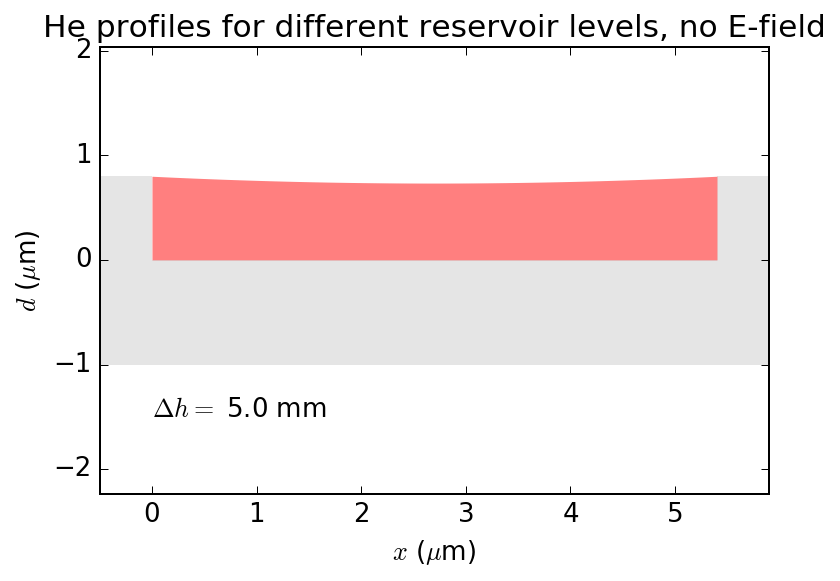

In [154]:
constants, parameters = reset_constants(verbose=False)
parameters['d0'] = 0.8E-6 # depth of the channel
parameters['w'] = 5.4E-6 # width of the channel

x = linspace(0, parameters['w'], 1E3)
hmin = constants['sigma']/(constants['rho']*constants['g']*0.5*parameters['w'])
hmax = constants['sigma']/(constants['rho']*constants['g']*1000*parameters['w'])

xmin = -0.5
xmax = parameters['w']*1E6+0.5

fig=plt.figure(figsize=(6.,4.))
common.configure_axes(13)

def vary_height_and_plot(h=5E-3):
    parameters['h'] = h
    draw_channel(parameters, [-5, 0])
    draw_channel(parameters, [parameters['w']*1E6, parameters['w']*1E6+5])
    plt.fill_between(x*1E6, z(constants, parameters, x)*1E6, y2=0, color='red', alpha=0.5, lw=0.0)
    plt.xlabel('$x$ ($\mu$m)')
    plt.ylabel('$d$ ($\mu$m)')
    plt.xlim(xmin, xmax)
    plt.title("He profiles for different reservoir levels, no E-field")
    plt.fill_between([-0.5, 6], [-1.0, -1.0], y2=0, alpha=0.2, color='gray', lw=0)
    plt.axes().set_aspect('equal', 'datalim')
    plt.text(0, -1.5, "$\Delta h = $ {:.1f} mm".format(h*1E3))
    ax = plt.gca()
    ax.set_axis_bgcolor('none')
    
interact(vary_height_and_plot, h=(0E-3, 100E-3, 0.5E-3));

# Resonator DC bias potential

In [229]:
# Load the data from the dsp file: 
path = r'/mnt/s/_Data/160513 - EonHe M016v5/data/simulation/Maxwell/160525 - Resonator XZ cut/160524 - M016v5 resonator xz cut.dsp'
#path = r'S:\_Data\160513 - EonHe M016v5\data\simulation\Maxwell\160525 - Resonator XZ cut\160530 - M016v5 resonator xz cut magE.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ==============  ================
Parameter        Value             Std
===========  ==============  ================
a0           0.731286176903  4.8231242201e-06
a1           -3214.87269732   161.129423096
===========  ==============  ================
f = 5.352 +/- 0.134 GHz


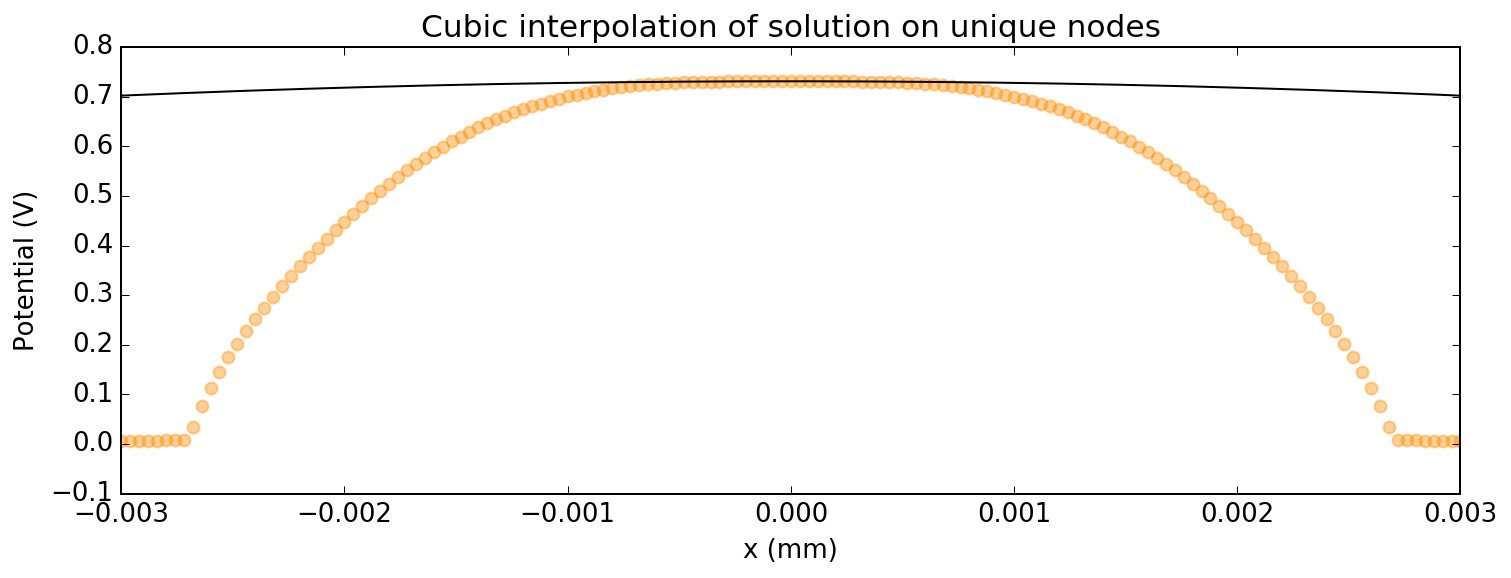

In [230]:
h = 0.78E-3
fitdomain=(-0.25E-3, 0.25E-3)

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
# xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
#                                                      yeval=np.linspace(0, 8E-3, 1001), clim=(0, 1), 
#                                                      plot_axes='xy', cmap=plt.cm.viridis)

# plt.hlines(h, bounding_box[0], bounding_box[1], linestyles='--', color='darkorange')

xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=np.linspace(-10E-3, 10E-3, 501), 
                                                     yeval=h, clim=(0.00, 1.00), plot_axes='xy', linestyle='None',
                                                     cmap=plt.cm.viridis, **common.plot_opt("darkorange", msize=6))
plt.ylim(-0.1, 0.8)
plt.xlim(-3E-3, 3E-3)
ax = plt.gca()
ax.set_axis_bgcolor('none')
fr, ferr = kfit.fit_poly(xinterp[0], Uinterp[0], mode='even', fitparams=[0,- 0.01], domain=fitdomain)
plt.plot(xinterp[0], kfit.polyfunc_even(xinterp[0], *fr), color='k')

t = trap_analysis.TrapSolver()
t.get_electron_frequency([fr[0], fr[1]/1E6], [ferr[0], ferr[1]/1E6]);

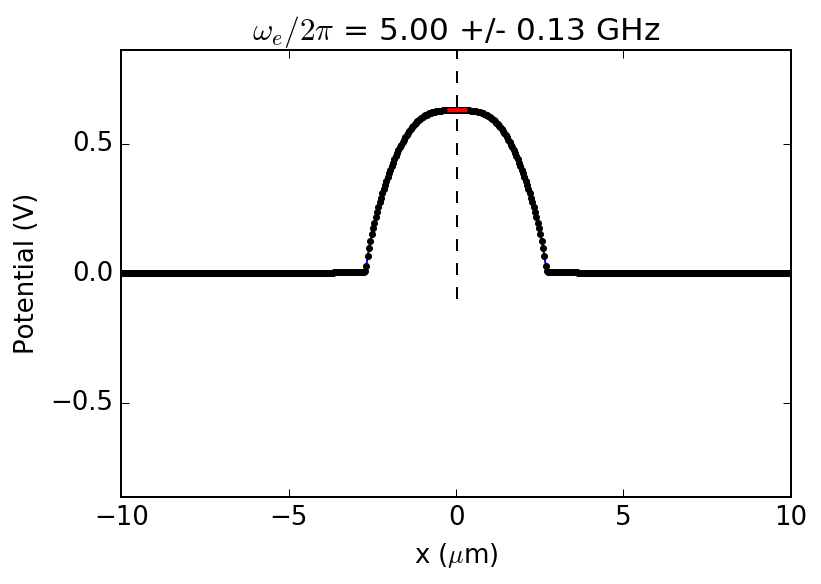

In [160]:
t = trap_analysis.TrapSolver()

pinw = 1.2
gapw = 1.0

def plot_resonator_potential(resonator_voltage=0.6):
    plt.figure(figsize=(6.,4.))
    voltage = resonator_voltage
    V = voltage*Uinterp[0]
    X = xinterp[0]*1E3
    Y = yinterp[0]*1E3
    
    plt.plot(X, V)
    plt.xlim(min(X), max(X))
    plt.title('$h$ = %.2f $\mu$m, Feature size: 1 $\mu$m'%(h*1E6))
  
    if voltage >= 0:
        try:
            fr, ferr = t.fit_electron_potential(X, V, fitdomain=(X[np.argmax(V)]-0.25, 
                                                                 X[np.argmax(V)]+0.25), do_plot=True)
            f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
        except:
            f0, sigmaf0 = np.nan, np.nan
        plt.ylim(-voltage, voltage)
    else:
        f0, sigmaf0 = np.nan, np.nan
        plt.plot(X, V, '.k')
        plt.ylim(voltage, -voltage)
        
    plt.vlines(X[np.argmax(V)], ymin=-0.1, ymax=3.0, colors='k', linestyles='--')
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("Potential (V)")
    plt.title("$\omega_e/2\pi$ = {:.2f} +/- {:.2f} GHz".format(f0/1E9, sigmaf0/1E9))
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    ax = plt.gca()
    ax.set_axis_bgcolor('none')
    #plt.ylim(-1, ymax)
    
interact(plot_resonator_potential, resonator_voltage=(0.01, 5, 0.05));

# Single electron interacting with the resonator

100%|██████████| 1001/1001 [00:03<00:00, 316.82it/s]


(1001, 2)


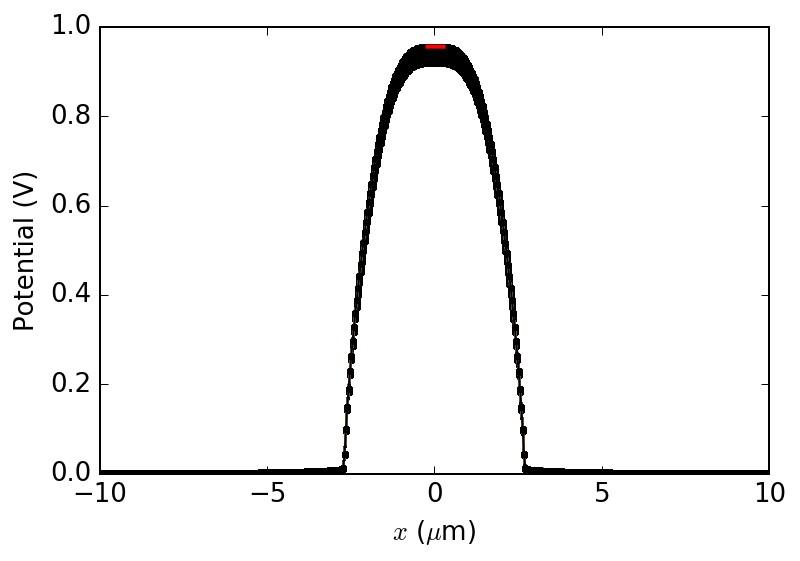

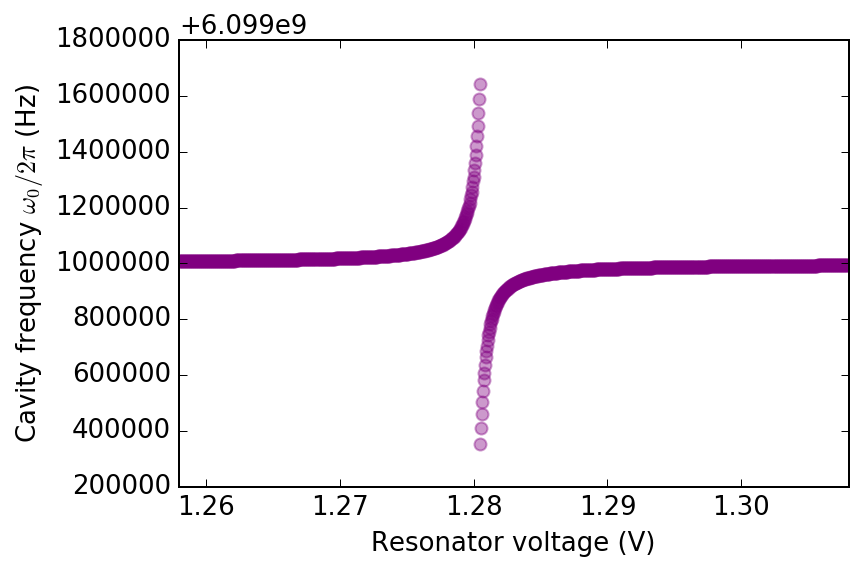

In [164]:
t = trap_analysis.TrapSolver()

#:param alpha: Quadratic component of the DC trapping potential in V/um**2
#:param beta: Linear component of the resonator differential mode potential in V/um.
#:param f0: Bare cavity frequency, without electrons, in Hz
#:param P: Power of the input drive in dBm
#:param Q: Q of the microwave cavity
#:return: 2 eigenvalues, one of which is the cavity frequency and one the electron frequency in Hz.

center = 1.283
span = 0.05

resVs = np.linspace(center-span/2., center+span/2., 1001)
resfreqs = list()
plt.figure(figsize=(6.,4.))

for voltage in tqdm(resVs):
    V = voltage*Uinterp[0]
    X = xinterp[0]*1E3
    Y = yinterp[0]*1E3

    plt.plot(X, V)
    plt.xlim(min(X), max(X))

    fr, ferr = t.fit_electron_potential(X, V, fitdomain=(X[np.argmax(V)]-0.25, X[np.argmax(V)]+0.25), do_plot=True)
    f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    
    alpha = -fr[1]
    beta = 0.29 #V/um, from the top of this notebook
    f0 = 6.10E9
    
    # Both changing the power and the Q of the resonator leads to a stronger signal
    Q = 1E4
    P = -50

    f1, f2 = t.get_eigenfreqencies(alpha, beta, f0, P, Q)
    resfreqs.append([f1, f2])

print np.shape(np.array(resfreqs)) 
resfreqs = np.array(resfreqs)

plt.figure(figsize=(6.,4.))
plt.plot(resVs, resfreqs[:,0], linestyle='None', **common.plot_opt('purple', msize=6))
plt.xlim(np.min(resVs), np.max(resVs));
plt.xlabel("Resonator voltage (V)")
plt.ylabel("Cavity frequency $\omega_0/2\pi$ (Hz)")
ax = plt.gca()
ax.set_axis_bgcolor('none')

# Greater trap area simulation

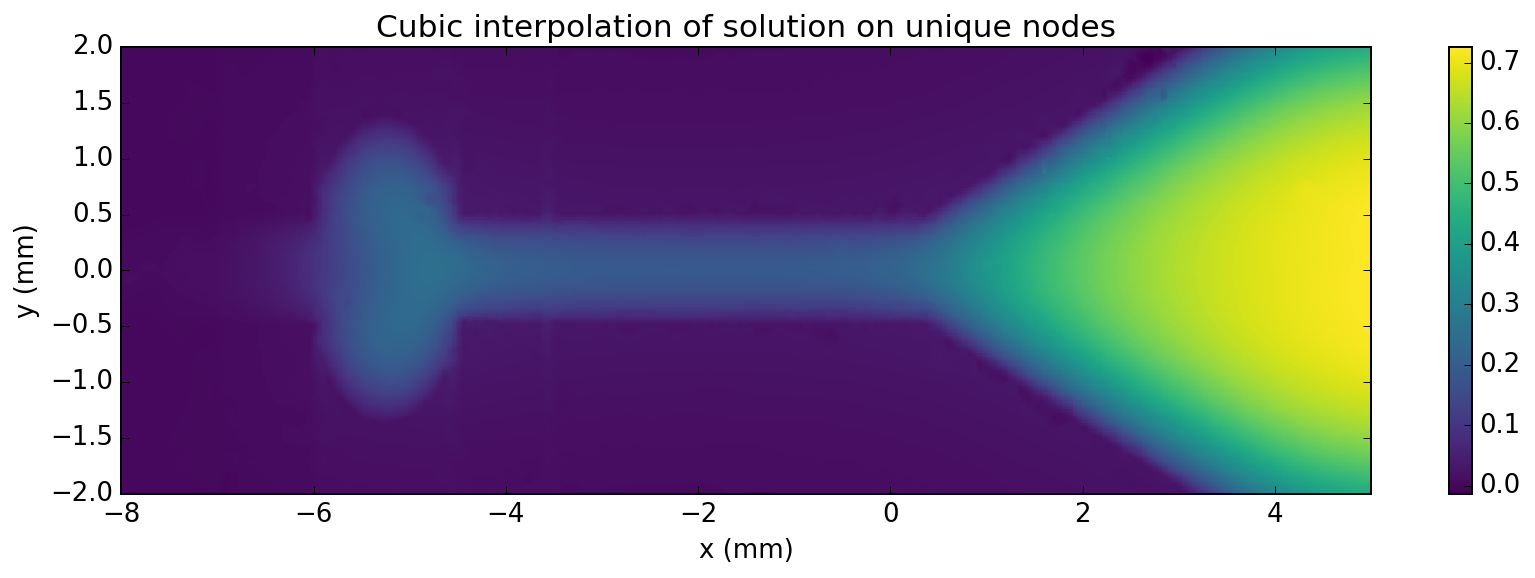

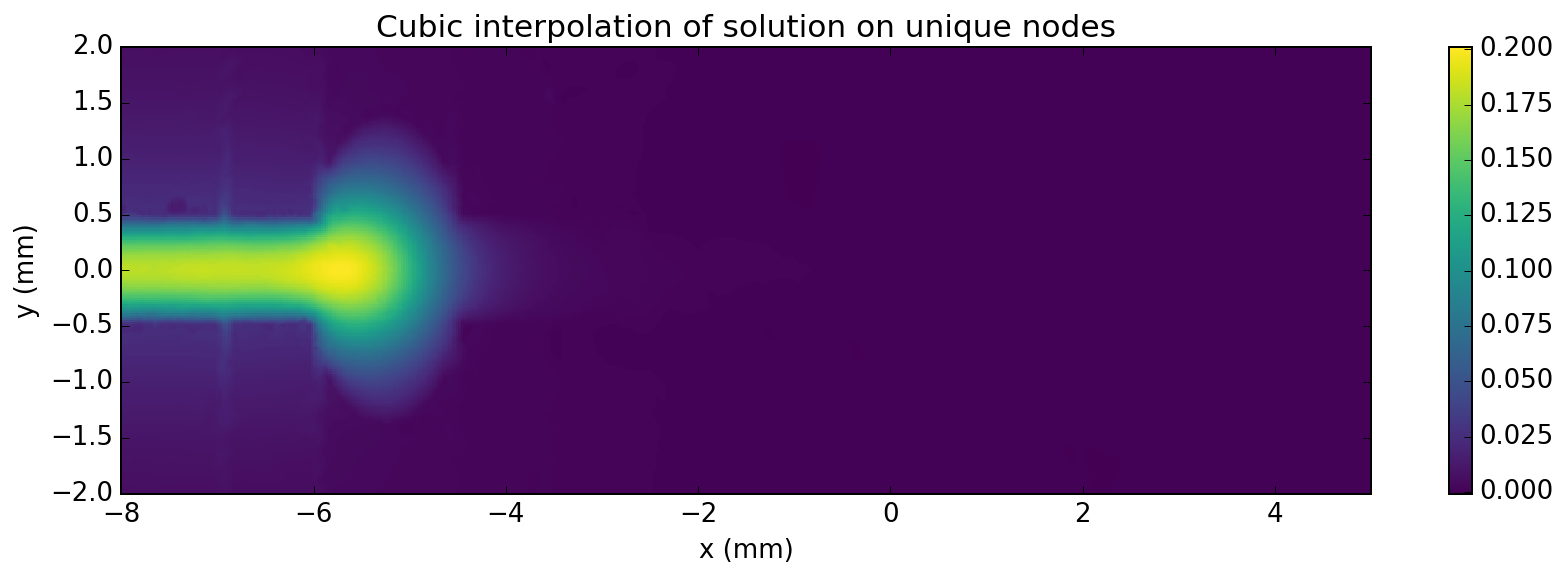

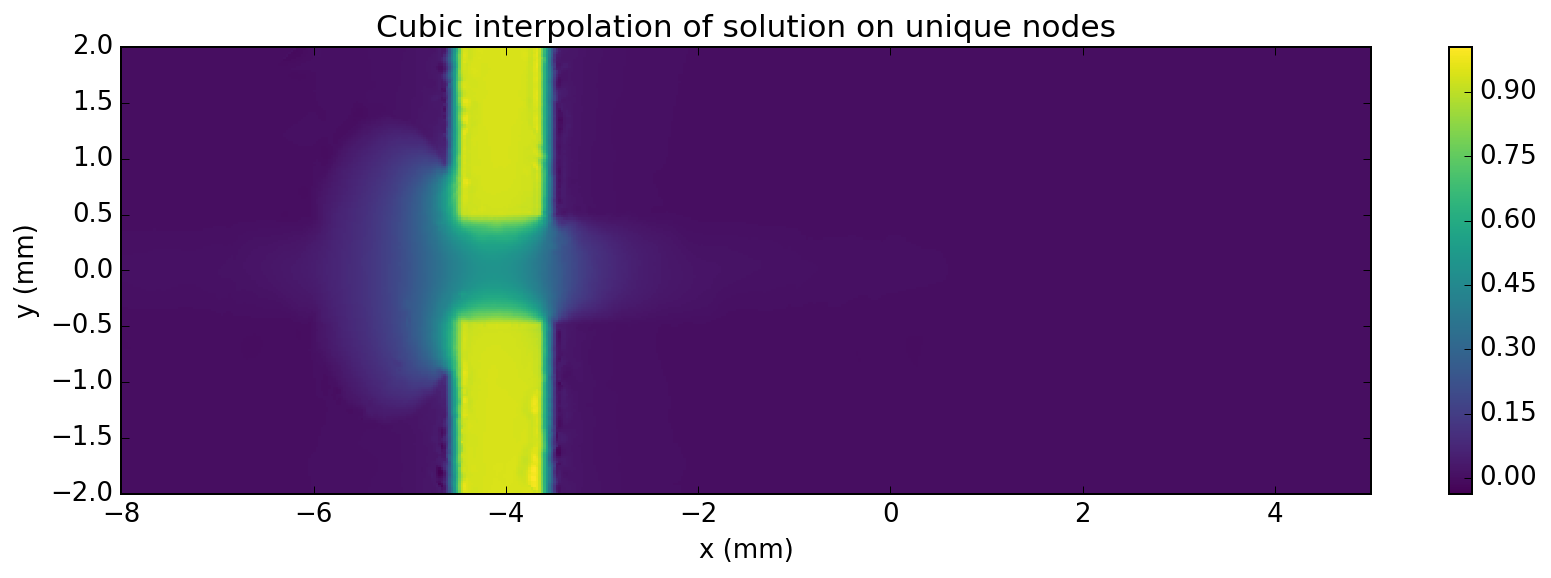

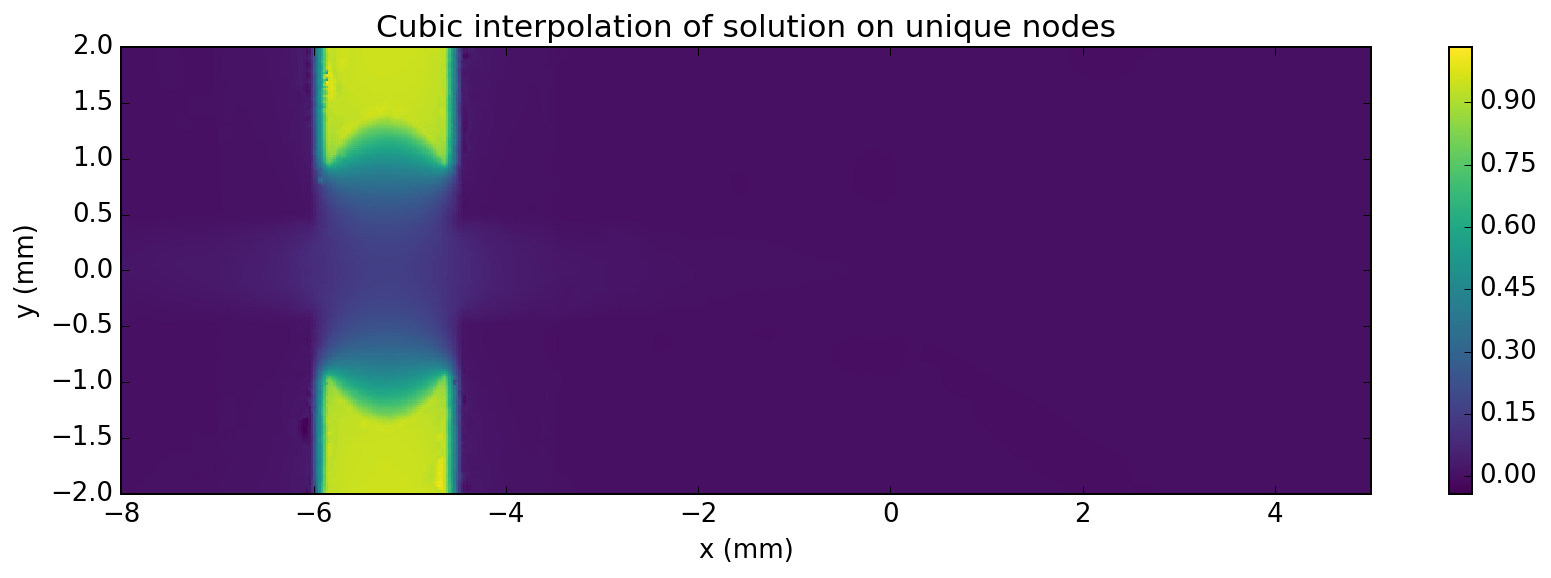

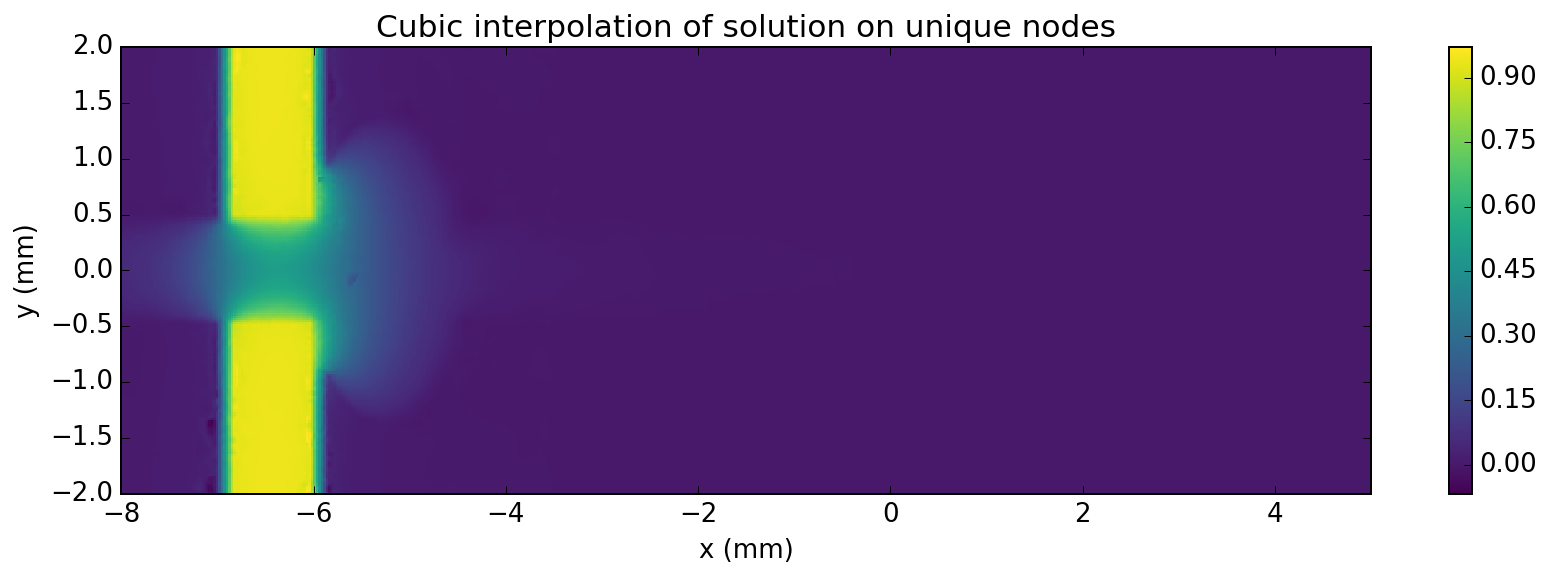

In [3]:
# Evaluate all files in the range
xeval=np.linspace(-8, 5, 501)
yeval = np.linspace(-2, 2, 201)


datafiles = ["data/simulation/Maxwell/160608 - Greater trap area/Greater Trap Area xy - Resonator.dsp",
             "data/simulation/Maxwell/160608 - Greater trap area/Greater Trap Area xy - Trap.dsp",
             "data/simulation/Maxwell/160608 - Greater trap area/Greater Trap Area xy - Guard Res.dsp",
             "data/simulation/Maxwell/160608 - Greater trap area/Greater Trap Area xy - Guard Center.dsp", 
             "data/simulation/Maxwell/160608 - Greater trap area/Greater Trap Area xy - Guard Trap.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})


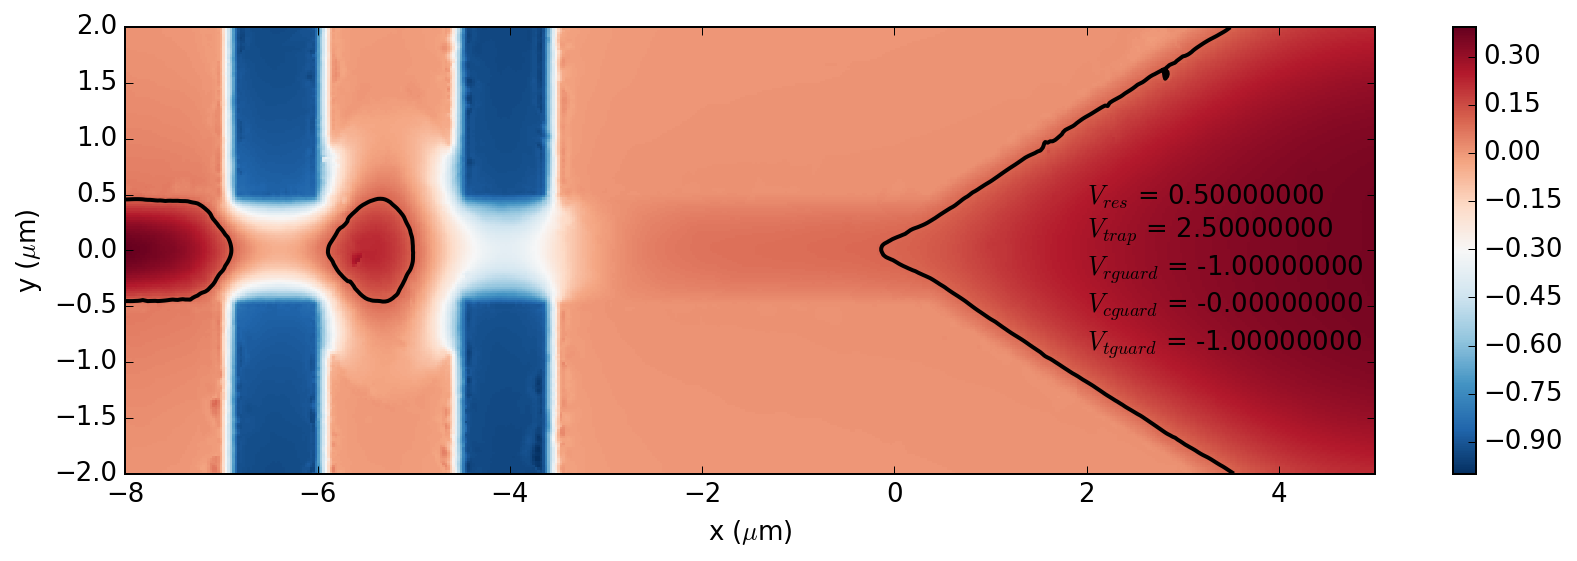

In [4]:
t = trap_analysis.TrapSolver()
x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)

import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (14.,4.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.5, trap=+2.5, resonatorguard=-1.0, centerguard=-0.0, trapguard=-1.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, chemical_potential=0.1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, 
                            auto_scale=True):
    
    fig = plt.figure()
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    if not auto_scale:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    
    ymin, ymax = np.min(y), np.max(y)
    
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("y ($\mu$m)")
    plt.colorbar()
    plt.xlim(np.min(x), np.max(x))
    plt.ylim(ymin, ymax)
    
    levels = np.array([chemical_potential])
    CS = plt.contour(x, y, combined_potential, levels, origin='lower', linewidths=2, colors='k')
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)
    
    plt.text(2, ymin + 0.2*(ymax-ymin), biasVoltages)
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), chemical_potential=(-5, 5, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, auto_scale=True);

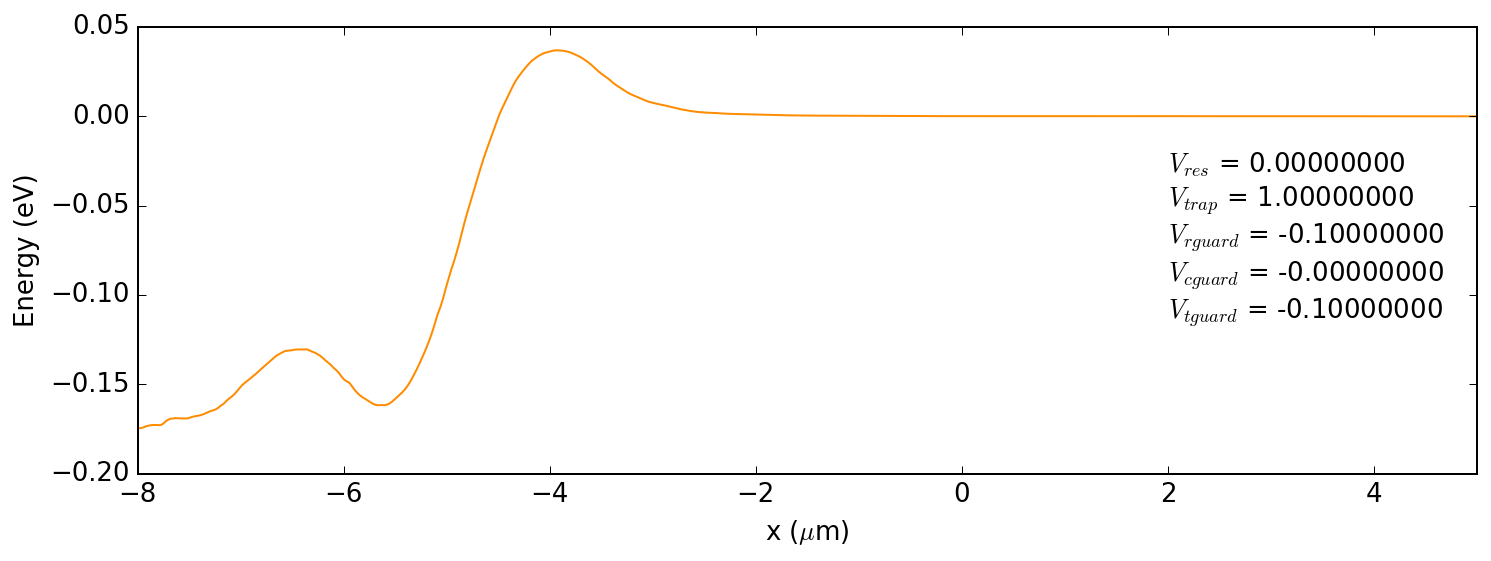

In [5]:
t = trap_analysis.TrapSolver()
x, y, cropped_potentials = t.crop_potentials(output, ydomain=None, xdomain=None)

import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,4.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+0.35, trap=+0.05, resonatorguard=-0.12, centerguard=-0.0, trapguard=-0.10, scaling=0.0, 
                            color_minimum=-0.10, color_maximum=0.10, chemical_potential=0.1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, 
                            auto_scale=False):
    
    fig = plt.figure()
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)

    centeridx = np.shape(y)[0]/2
    plt.plot(x, -combined_potential[centeridx,:], color='darkorange')
    plt.gca().set_axis_bgcolor('none')
        
    ymin, ymax = np.min(-combined_potential[centeridx,:]), np.max(-combined_potential[centeridx,:])
    
    plt.xlabel("x ($\mu$m)")
    plt.ylabel("Energy (eV)")
    plt.xlim(np.min(x), np.max(x))
    if not auto_scale:
        plt.ylim(color_minimum, color_maximum)
        
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)
    
    plt.text(2, ymin + 0.2*(ymax-ymin), biasVoltages)
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         chemical_potential=(-5, 5, 0.05), color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05), 
         resonator_trap_locked=False, left_right_guard_locked=False, auto_scale=True);

# Trap area simulation

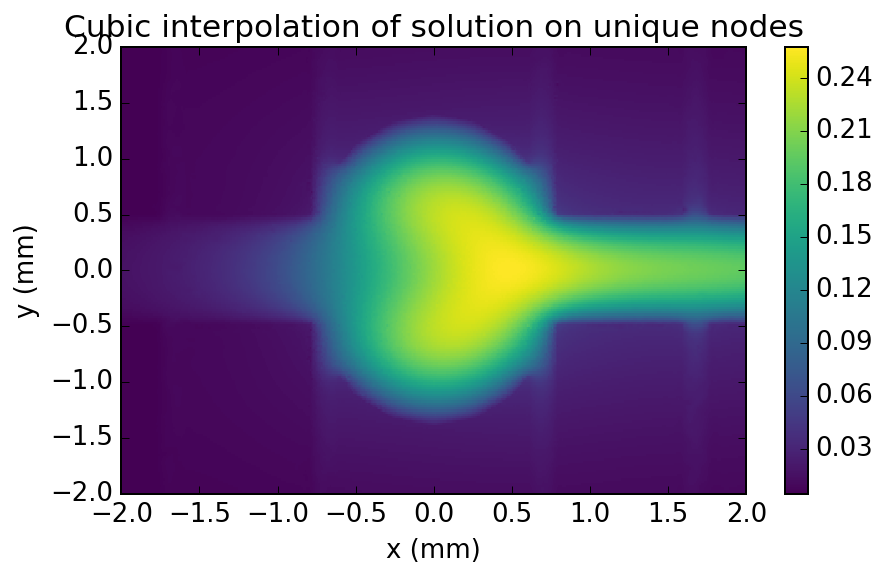

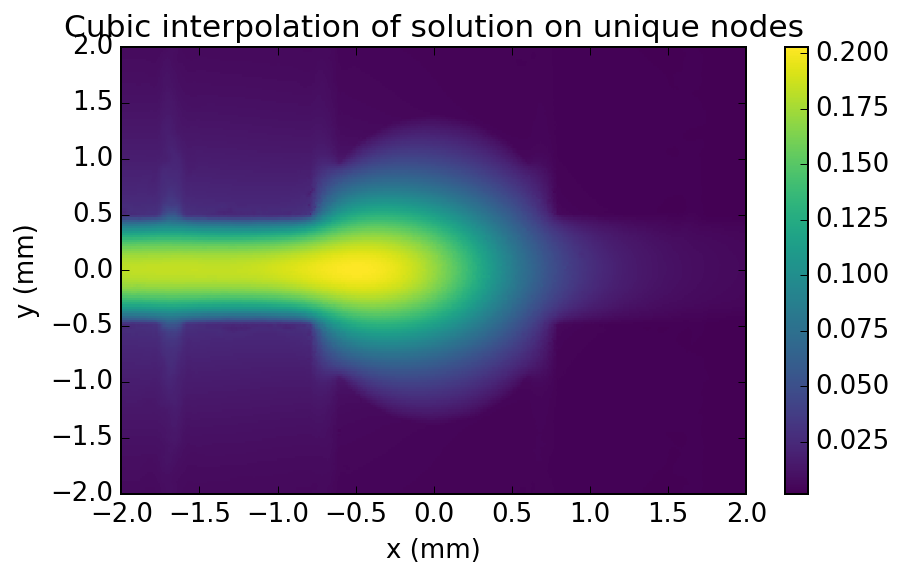

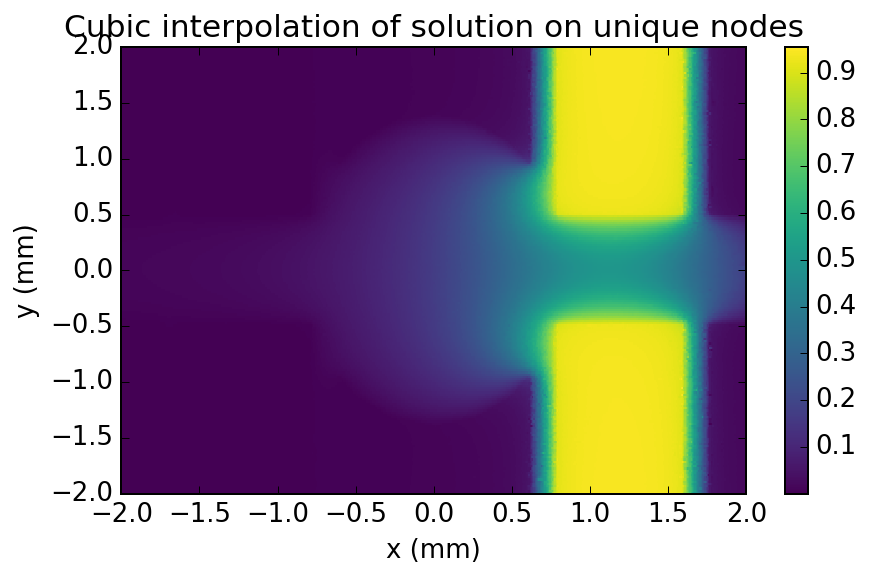

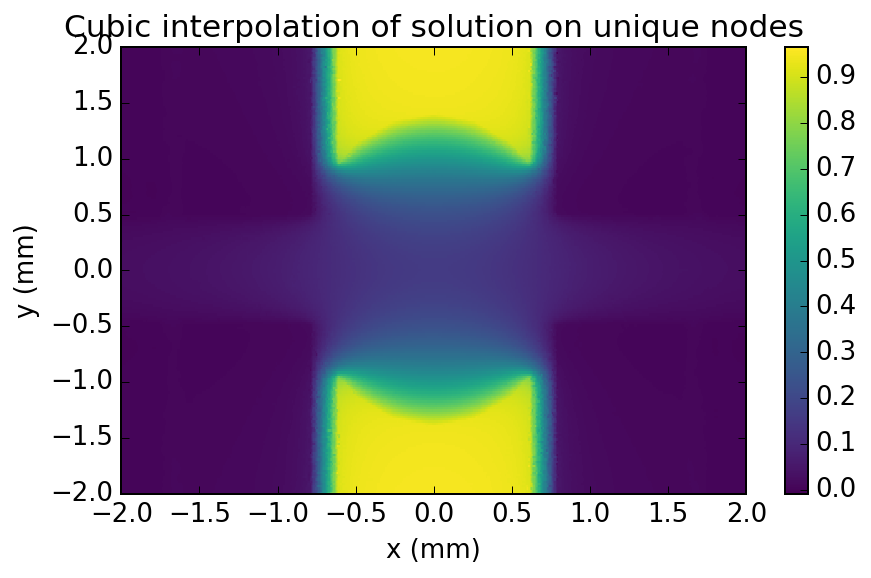

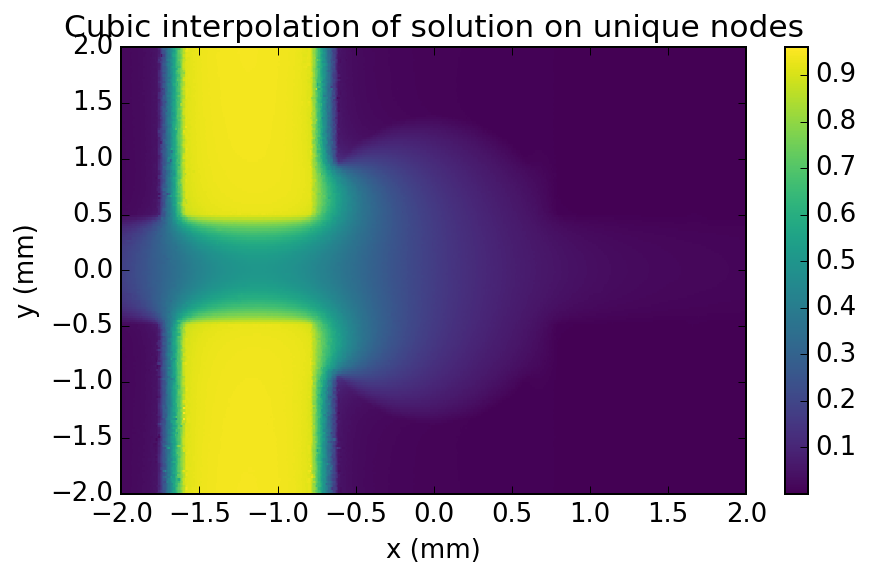

In [38]:
# Evaluate all files in the range
xeval=np.linspace(-2, 2, 501)
yeval = np.linspace(-2, 2, 201)


datafiles = ["data/simulation/Maxwell/160528 - Trap area - fine mesh/0000 160528 - M016v5 trap xy (resonator) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0001 160528 - M016v5 trap xy (trap) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0002 160528 - M016v5 trap xyz (guardres) fine mesh.dsp",
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0003 160528 - M016v5 trap xyz (guardcenter) fine mesh.dsp", 
             "data/simulation/Maxwell/160528 - Trap area - fine mesh/0004 160528 - M016v5 trap xyz (guardtrap) fine mesh.dsp"]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(7.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join('/mnt/s/_Data/160513 - EonHe M016v5', datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=None, 
                                                         plot_axes='xy', cmap=plt.cm.viridis, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})

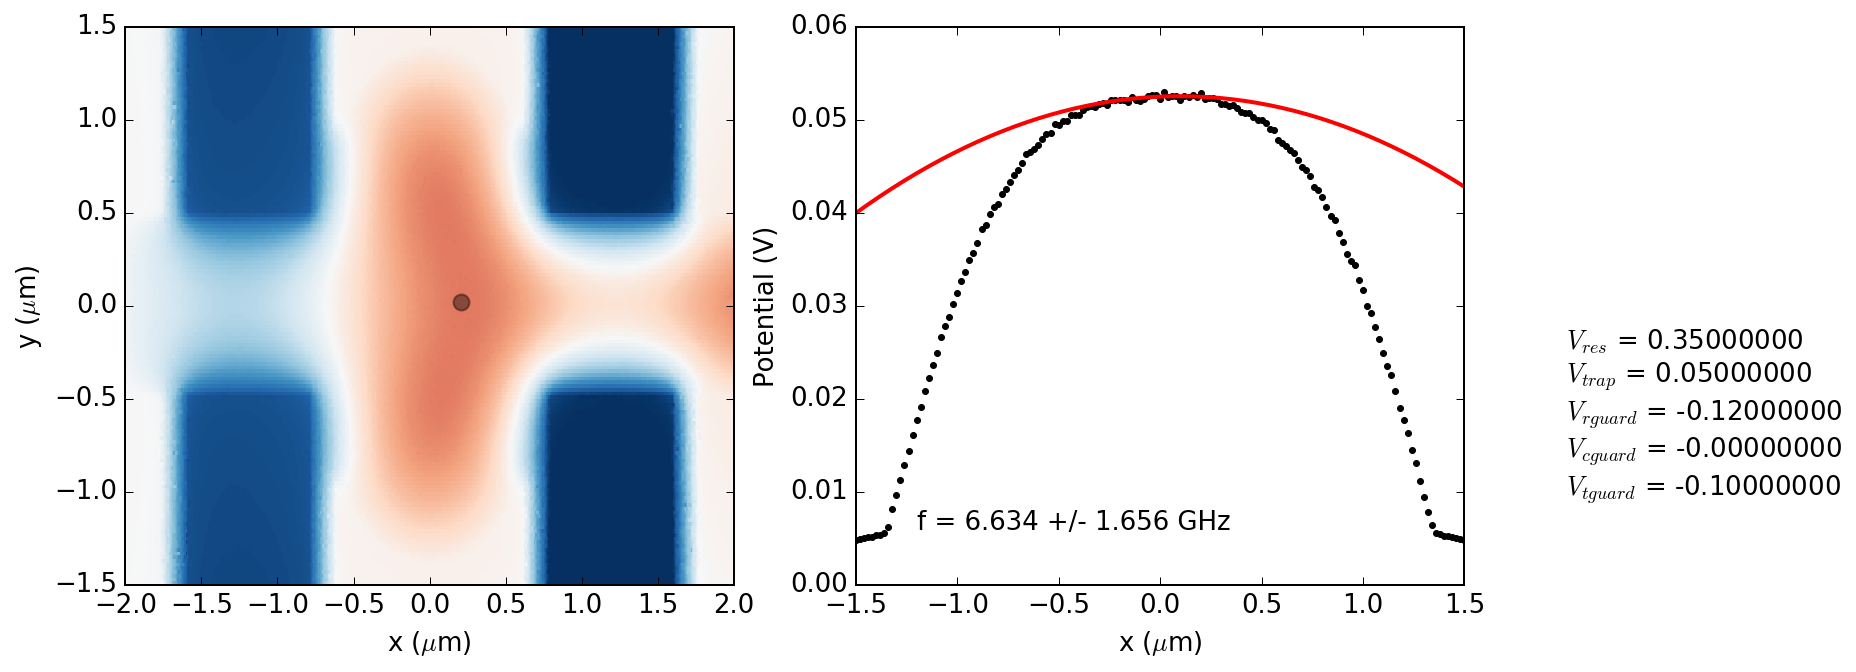

In [39]:
%matplotlib inline

x, y, cropped_potentials = t.crop_potentials(output, xdomain=(-2.0,2.0), ydomain=(-1.5, 1.5))
import matplotlib as mpl
common.configure_axes(13)
mpl.rcParams['figure.figsize'] = (12.,5.)
#plt.figure(figsize=(7.,4.))

def plot_combined_potential(resonator=+2.25, trap=+1.20, resonatorguard=-3.0, centerguard=-0.0, trapguard=-3.0, scaling=0.0, 
                            color_minimum=-1, color_maximum=1, 
                            resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
                            auto_scale=True):
    
    fig = plt.figure()
    plt1 = fig.add_subplot(1,2,1)
    plt2 = fig.add_subplot(1,2,2)
    
    if resonator_trap_locked:
        trap = resonator
    if left_right_guard_locked:
        resonatorguard = trapguard
    coefficients = np.array([resonator, trap, resonatorguard, centerguard, trapguard]) * 10**scaling
    combined_potential = t.get_combined_potential(cropped_potentials, coefficients)
    #plt.pcolormesh(x*1E6, y*1E6, combined_potential, cmap=plt.cm.RdBu_r, vmin=-1, vmax=1)
    #plt1.imshow(combined_potential, extent=[min(x)*1E6, max(x)*1E6, min(y)*1E6, max(y)*1E6], cmap=plt.cm.RdBu_r,
    #           aspect='auto', interpolation='none')
    if not auto_scale:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r, 
                        vmin=color_minimum, vmax=color_maximum)
    else:
        plt1.pcolormesh(x, y, combined_potential, cmap=plt.cm.RdBu_r)
    if fit_potential_minimum:
        yidx,xidx = np.where(combined_potential==np.max(combined_potential))
    else: 
        yidx = np.array([common.find_nearest(y, 0.0)])
        xidx = np.array([common.find_nearest(x, 0.0)])
    plt1.plot(x[xidx], y[yidx], 'o', **common.plot_opt("black"))
    
    #print yidx, xidx
    #print np.shape(yidx), np.shape(xidx)
    
    #cb.outline.set_visible(False)
    #cb.ax.set_ylabel("Voltage (V)")
    
    plt1.set_xlabel("x ($\mu$m)")
    plt1.set_ylabel("y ($\mu$m)")
    
    Vdata = combined_potential[:,xidx[0]]
    xdata = y
    plt2.plot(xdata, Vdata, '.k')
    
    try:
        fr, ferr = t.fit_electron_potential(xdata, Vdata, fitdomain=(-0.25, +0.25), do_plot=False)
        plt2.plot(xdata, kfit.parabolafunc(xdata, *fr), '-r', lw=2.0)
        f0, sigmaf0 = t.get_electron_frequency(fr, ferr, verbose=False)
    except:
        f0, sigmaf0 = 0, 0
    
    plt2.set_xlabel("x ($\mu$m)")
    plt2.set_ylabel("Potential (V)")
    #plt2.set_ylim(-1, 1)
    plt2.set_xlim(min(xdata), max(xdata))
    plt.gca().set_axis_bgcolor('none')
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt2.text(xmin + 0.1*(xmax-xmin), ymin + 0.1*(ymax-ymin), "f = %.3f +/- %.3f GHz"%(f0/1E9, sigmaf0/1E9))
    
    biasVoltages = "$V_{res}$ = %.8f\n$V_{trap}$ = %.8f\n$V_{rguard}$ = %.8f\n$V_{cguard}$ = %.8f\n$V_{tguard}$ = %.8f\n" % \
    (resonator * 10**scaling, trap * 10**scaling, resonatorguard * 10**scaling, centerguard * 10**scaling, trapguard * 10**scaling)
    
    plt2.text(2, ymin + 0.1*(ymax-ymin), biasVoltages)
    plt.show()
    
interact(plot_combined_potential, resonator=(-5.0, 5.0, 0.05), trap=(-5, 5, 0.05), 
         resonatorguard=(-5, 5, 0.05), centerguard=(-5, 5, 0.05), trapguard=(-5, 5, 0.05), scaling=(-2.0, 1.0, 0.01),
         color_minimum=(-5, 5, 0.05), color_maximum=(-5, 5, 0.05),
         resonator_trap_locked=False, left_right_guard_locked=False, fit_potential_minimum=True, 
         auto_scale=True);

# Electron configuration in trap